In [1]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib inline
# notebook is not supported in VS code instead used inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr
import matplotlib.cm as cm
import seaborn as sns # for statistical data visualization
from sklearn.cluster import KMeans
from netCDF4 import Dataset
from scipy.stats import norm

Data paths

In [1]:
gap_filled_SWE = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/SWE_1979_2022_gapfilled_basin05BB001_Bow.nc'
CAPA_precip = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Pobs.csv'
precip_coordinates = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/GeoData.csv'
Bow_at_Banff_shapefile = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Bow_at_Banff/basins_testcases.shp'
SCDNA_precipt_data = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/SCDNA_v1.1.nc4'

In [3]:
SWE = xr.open_dataset(gap_filled_SWE)

SWE_testbasin = SWE.to_dataframe()

#display(SWE_testbasin)

print(SWE_testbasin)

                              SWE  flag donor_stations        lat         lon  \
time       station_id                                                           
1979-01-01 ALE-05BA811        NaN   NaN                 51.700001 -116.466667   
           SCD-AL003          NaN   NaN                 51.183334 -115.566666   
           ALE-05BA801        NaN   NaN                 51.416668 -116.183334   
           ALE-05BA802        NaN   NaN                 51.433334 -116.166664   
           ALE-05BA806        NaN   NaN                 51.416668 -116.233330   
...                           ...   ...            ...        ...         ...   
2022-07-31 ALE-05BA814        NaN   0.0                 51.683334 -116.383331   
           ALE-05BB803        NaN   0.0                 51.083332 -115.783333   
           ALE-05CA805        NaN   0.0                 51.533333 -116.050003   
           ALE-05BB803P  40.11483   0.0                 51.083332 -115.783333   
           ALE-05CA805P   3.

In [4]:
#Take mean SWE for each day for whole basin
daily_mean_SWE = SWE_testbasin.groupby('time')['SWE'].mean().reset_index()

# Rename the columns for clarity
daily_mean_SWE.columns = ['Date', 'mean_SWE']

# Display the result
print(daily_mean_SWE)

            Date    mean_SWE
0     1979-01-01  115.586667
1     1979-01-02  115.490000
2     1979-01-03  115.360000
3     1979-01-04  115.263333
4     1979-01-05  115.173333
...          ...         ...
15913 2022-07-27   21.446791
15914 2022-07-28   21.756103
15915 2022-07-29   22.024836
15916 2022-07-30   21.994835
15917 2022-07-31   22.005415

[15918 rows x 2 columns]


In [5]:
#Filter data points inside the shapefile

basin_cood = pd.read_csv(precip_coordinates)
basin_cood_selected = basin_cood[['subid','longitude','latitude']]
geometry_basin = [Point(lon, lat) for lon, lat in zip(basin_cood_selected['longitude'], basin_cood_selected['latitude'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
gdf_basin = gpd.GeoDataFrame(basin_cood_selected, geometry=geometry_basin, crs="EPSG:4326").reset_index()


print(gdf_basin.head()) 

   index    subid   longitude   latitude                     geometry
0      0  9034134 -111.430980  54.102901  POINT (-111.43098 54.10290)
1      1  9033741 -111.500813  54.184221  POINT (-111.50081 54.18422)
2      2  9033746 -111.587321  54.201127  POINT (-111.58732 54.20113)
3      3  9033320 -111.652629  54.205722  POINT (-111.65263 54.20572)
4      4  9050892 -110.412325  55.259742  POINT (-110.41232 55.25974)


In [6]:
#Select points within the shapefile
shapefile = gpd.read_file(Bow_at_Banff_shapefile)

Bow_shapefile = shapefile[shapefile["Station_Na"]=="BOW RIVER AT BANFF"]

points_within = gpd.sjoin(gdf_basin,Bow_shapefile,how='inner',op='within')
precip_points = points_within.drop(columns=['index','index_right','Station_ID','Station_Na','Area_km2','Source'])
#precip_points.to_csv('C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/filtered_points_cleaned.csv', index=False)

print(shapefile.head())
display(precip_points)

  Station_ID                                        Station_Na  Area_km2  \
0    05BB001                                BOW RIVER AT BANFF  2210.560   
1   09081600  CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.   432.893   

      Source                                           geometry  
0  WSC_HYDAT  POLYGON ((-115.83512 51.07677, -115.83524 51.0...  
1       USGS  POLYGON ((-107.37697 39.21782, -107.37702 39.2...  


c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,subid,longitude,latitude,geometry
1993,4093209,-116.496226,51.645446,POINT (-116.49623 51.64545)
1994,4093223,-116.440287,51.593192,POINT (-116.44029 51.59319)
1995,4092987,-116.365370,51.659526,POINT (-116.36537 51.65953)
1996,4093051,-116.373838,51.590477,POINT (-116.37384 51.59048)
1997,4093049,-116.326148,51.568713,POINT (-116.32615 51.56871)
1998,4093046,-116.297106,51.566202,POINT (-116.29711 51.56620)
1999,4093025,-116.162294,51.583859,POINT (-116.16229 51.58386)
2000,4092697,-116.295351,51.496561,POINT (-116.29535 51.49656)
2001,4093024,-116.185246,51.448452,POINT (-116.18525 51.44845)
2002,4093155,-116.261405,51.394463,POINT (-116.26140 51.39446)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1783280047.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  precip_points['centroid'] = precip_points.centroid


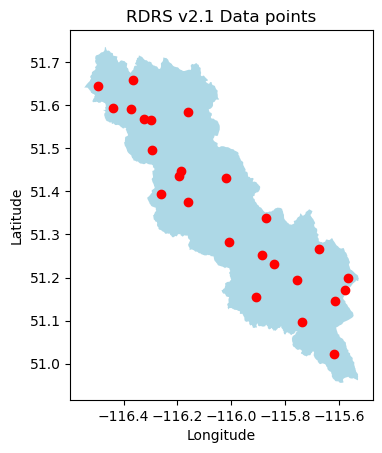

In [7]:
#plot ppt data points
fig, ax = plt.subplots()
Bow_shapefile.plot(ax=ax, color='lightblue')
# Extract coordinates
precip_points['centroid'] = precip_points.centroid
x_coords = precip_points['centroid'].x
y_coords = precip_points['centroid'].y

# Plot the coordinates
ax.scatter(x_coords, y_coords, color='red', marker='o', label="Centroids")
plt.title("RDRS v2.1 Data points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [8]:
#precipitation data
Precip_data = pd.read_csv(CAPA_precip)
print(Precip_data.head())

         Date  4000043  4000079  4000089  4000158  4000166  4000171  4000179  \
0  2000-01-01    0.000    0.011    0.000    0.000    0.000    0.000    0.024   
1  2000-01-02    0.191    0.080    0.054    0.104    0.046    0.127    0.233   
2  2000-01-03    0.048    0.004    0.003    0.006    0.004    0.058    0.025   
3  2000-01-04    0.341    0.293    0.278    0.316    0.241    0.302    0.329   
4  2000-01-05    0.001    0.017    0.017    0.009    0.018    0.001    0.005   

   4000197  4000215  ...  9054133  9054145  9054157  9054195  9054216  \
0    0.000    0.001  ...    0.094    0.001    0.065    0.014    0.000   
1    0.232    0.302  ...    0.106    0.019    0.142    0.033    0.000   
2    0.061    0.059  ...    0.046    0.009    0.066    0.088    0.011   
3    0.309    0.305  ...    0.073    0.009    0.089    0.010    0.051   
4    0.007    0.001  ...    0.043    0.001    0.062    0.000    0.008   

   9054229  9054237  9054260  9054270  9054290  
0    0.000    0.000    0.002   

In [9]:
# Get the list of subids from the second dataset (station IDs you're interested in)
subids = precip_points['subid'].astype(str).tolist()

# Filter the first dataset to only include the Date column and the columns matching the subids
filtered_precip_data = Precip_data[['Date'] + [col for col in Precip_data.columns if col in subids]]

# Display the filtered DataFrame
print(filtered_precip_data.head())


         Date  4092332  4092333  4092419  4092442  4092475  4092506  4092599  \
0  2000-01-01    0.097    0.097    0.401    0.401    0.600    0.264    0.791   
1  2000-01-02    1.341    1.341    1.950    1.950    1.645    1.634    1.895   
2  2000-01-03    0.444    0.444    0.972    0.972    0.951    0.723    1.257   
3  2000-01-04    0.455    0.455    1.516    1.516    1.252    0.916    2.020   
4  2000-01-05    0.550    0.550    1.369    1.369    3.155    1.087    4.578   

   4092640  4092684  ...  4092987  4093023  4093024  4093025  4093046  \
0    0.236    0.200  ...    0.319    0.430    0.693    0.255    0.358   
1    1.711    1.195  ...    1.039    1.480    1.780    1.123    1.131   
2    0.690    0.576  ...    1.172    0.755    1.248    0.827    1.123   
3    0.914    0.519  ...    2.232    1.343    2.121    1.365    2.528   
4    0.910    0.995  ...    4.341    4.758    5.060    3.829    4.633   

   4093049  4093051  4093155  4093209  4093223  
0    0.358    0.588    0.947   

In [10]:
# Calculate the mean across all station columns for each day
filtered_precip_data['mean_precip'] = filtered_precip_data.iloc[:, 1:].mean(axis=1)*10

mean_ppt = filtered_precip_data[['Date', 'mean_precip']]
mean_ppt['Date'] = pd.to_datetime(mean_ppt['Date'])

# Display the first few rows of the DataFrame to see the result
print(mean_ppt)



           Date  mean_precip
0    2000-01-01       4.1820
1    2000-01-02      15.2904
2    2000-01-03      10.2452
3    2000-01-04      17.9920
4    2000-01-05      33.1588
...         ...          ...
6571 2017-12-28      17.4788
6572 2017-12-29      46.1504
6573 2017-12-30      77.2660
6574 2017-12-31       0.5376
6575 2018-01-01       0.2192

[6576 rows x 2 columns]


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1340444390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_precip_data['mean_precip'] = filtered_precip_data.iloc[:, 1:].mean(axis=1)*10
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1340444390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ppt['Date'] = pd.to_datetime(mean_ppt['Date'])


In [11]:
# Find the common dates between the two datasets
common_dates = pd.Series(daily_mean_SWE['Date']).isin(mean_ppt['Date'])

# Filter each dataset for the common dates
mean_SWE_filtered = daily_mean_SWE[daily_mean_SWE['Date'].isin(mean_ppt['Date'])]


mean = pd.merge(mean_SWE_filtered,mean_ppt[['Date','mean_precip']],on = 'Date', how='inner')

# Display the filtered datasets
print(mean)



           Date    mean_SWE  mean_precip
0    2000-01-01  312.213446       4.1820
1    2000-01-02  315.239070      15.2904
2    2000-01-03  315.304694      10.2452
3    2000-01-04  355.258094      17.9920
4    2000-01-05  317.099281      33.1588
...         ...         ...          ...
6571 2017-12-28  212.868320      17.4788
6572 2017-12-29  215.199455      46.1504
6573 2017-12-30  218.319898      77.2660
6574 2017-12-31  219.392755       0.5376
6575 2018-01-01  219.613584       0.2192

[6576 rows x 3 columns]


In [12]:
# Extract the year and month-day for filtering
mean['Year'] = mean['Date'].dt.year
mean['Month-Day'] = mean['Date'].dt.strftime('%m-%d')

# Define the period of interest: November 1st to May 1st
november_to_may = (mean['Month-Day'] >= '11-01') | (mean['Month-Day'] <= '05-01')

# Filter the data for November to April, inclusive
filtered_data = mean[november_to_may].copy()

# Adjust the year to group by winter season (e.g., Nov 2000 to April 2001 is the 2000 season)
filtered_data['season_year'] = filtered_data['Year']
filtered_data.loc[filtered_data['Month-Day'] <= '05-01', 'season_year'] -= 1

# Calculate the mean SWE and precipitation for each season
seasonal_means = filtered_data.groupby('season_year')[['mean_SWE', 'mean_precip']].mean().reset_index()

# Remove the first and last entry to exclude incomplete seasons
#seasonal_means = seasonal_means.iloc[2:-1]

# Display the result
print(seasonal_means)

    season_year    mean_SWE  mean_precip
0          1999  351.242678    12.725302
1          2000  191.958261     8.667152
2          2001  267.123293    12.912007
3          2002  176.645956    11.712171
4          2003  225.954835     9.968940
5          2004  222.784246     9.865240
6          2005  219.428550     8.873804
7          2006  312.304331    15.102800
8          2007  219.141200    10.224033
9          2008  195.579663    10.147664
10         2009  209.540297     8.303697
11         2010  231.662858    16.166547
12         2011  285.467858    18.472212
13         2012  255.524097    12.356380
14         2013  236.114856    14.599901
15         2014  193.846205    11.578321
16         2015  228.989821    10.605816
17         2016  277.419380    13.521778
18         2017  142.239826    15.156968


In [13]:
# Set season parameters
start_month, start_day = 11, 1  # Start in November
end_month, end_day = 5, 1       # End in May

# Find the first date with 15 mm SWE each year to set as season start
mean['season_year'] = mean['Date'].apply(lambda x: x.year if x.month >= start_month else x.year - 1)
season_starts = mean[mean['mean_SWE'] >= 15].groupby('season_year')['Date'].min()

# Filter seasons based on season start and ensure they run through to April 1st of the next year
filtered_seasons = []

for year, start_date in season_starts.items():
    if start_date.month < start_month:
        continue  # Skip incomplete seasons at the beginning

    end_date = pd.Timestamp(year + 1, end_month, end_day)
    season_data = mean[(mean['Date'] >= start_date) & (mean['Date'] < end_date)]
    
    # Check if season has data from start_date to end_date (April 1st)
    if not season_data.empty and season_data['Date'].max() >= end_date - pd.Timedelta(days=1):
        filtered_seasons.append(season_data)

# Combine all complete seasons
complete_season_data = pd.concat(filtered_seasons, ignore_index=True)

print(complete_season_data.head())

# Adjust the year to group by winter season (e.g., Nov 2000 to April 2001 is the 2000 season)
complete_season_data['season_year'] = complete_season_data['Year']
complete_season_data.loc[complete_season_data['Month-Day'] <= '05-01', 'season_year'] -= 1

# Calculate the mean SWE and precipitation for each season
seasonal_mean = complete_season_data.groupby('season_year')[['mean_SWE', 'mean_precip']].mean().reset_index()

#seasonal_mean['mean_precip_mm'] = seasonal_mean['mean_precip']  

print(seasonal_mean.head())

        Date  mean_SWE  mean_precip  Year Month-Day  season_year
0 2000-11-01    28.055       2.0736  2000     11-01         2000
1 2000-11-02    27.990       0.0880  2000     11-02         2000
2 2000-11-03    28.115       4.3616  2000     11-03         2000
3 2000-11-04    35.980      16.6212  2000     11-04         2000
4 2000-11-05    35.555      14.6952  2000     11-05         2000
   season_year    mean_SWE  mean_precip
0         2000  191.495198     8.566729
1         2001  265.509260    12.979883
2         2002  175.046414    11.758957
3         2003  224.913502    10.023281
4         2004  222.003431     9.896398


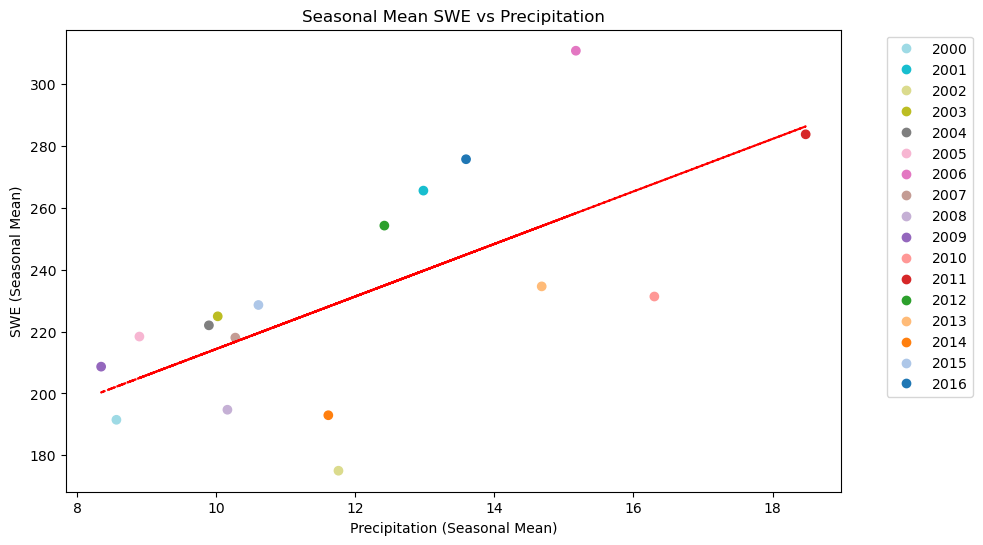

In [14]:
# Define colors based on the number of unique years
colors = cm.viridis(np.linspace(0, 1, len(seasonal_means)))

plt.figure(figsize=(10, 6))
ax=plt.scatter(seasonal_mean['mean_precip'],seasonal_mean['mean_SWE'],c=seasonal_mean['season_year'],cmap='tab20_r')
plt.xlabel('Precipitation (Seasonal Mean)')
plt.ylabel('SWE (Seasonal Mean)')
plt.legend(*ax.legend_elements(num=16),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Seasonal Mean SWE vs Precipitation')

z = np.polyfit(seasonal_mean['mean_precip'],seasonal_mean['mean_SWE'], 1)
p = np.poly1d(z)
plt.plot(seasonal_mean['mean_precip'], p(seasonal_mean['mean_precip']), "r--")
plt.show()

Snow drougth classification using Heldmyer et. al.


In [15]:
#daily accumulation period ratio

complete_season_data['cumulative_P'] = (complete_season_data.groupby('season_year')['mean_precip'].cumsum())
complete_season_data['SWE_P_ratio'] = complete_season_data['mean_SWE']/complete_season_data['cumulative_P']

print(complete_season_data.head())



        Date  mean_SWE  mean_precip  Year Month-Day  season_year  \
0 2000-11-01    28.055       2.0736  2000     11-01         2000   
1 2000-11-02    27.990       0.0880  2000     11-02         2000   
2 2000-11-03    28.115       4.3616  2000     11-03         2000   
3 2000-11-04    35.980      16.6212  2000     11-04         2000   
4 2000-11-05    35.555      14.6952  2000     11-05         2000   

   cumulative_P  SWE_P_ratio  
0        2.0736    13.529610  
1        2.1616    12.948742  
2        6.5232     4.310001  
3       23.1444     1.554588  
4       37.8396     0.939624  


In [16]:
# Specify the season year you are interested in
season_year = 2002  # Example: season starting in November 2022

# Define the date range for that specific season year
start_date = f'{season_year}-11-01'
end_date = f'{season_year + 1}-05-01'

# Filter data within this date range
season_data = mean[(mean['Date'] >= start_date) & (mean['Date'] <= end_date)]

# Set display options to show all rows
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if you have many columns)
# Print the filtered data
print(season_data.head())


           Date   mean_SWE  mean_precip  Year Month-Day  season_year
1035 2002-11-01  37.458375       0.0448  2002     11-01         2002
1036 2002-11-02  37.694595       0.0504  2002     11-02         2002
1037 2002-11-03  37.398415       0.0508  2002     11-03         2002
1038 2002-11-04  37.360311       0.2084  2002     11-04         2002
1039 2002-11-05  37.892361       0.1324  2002     11-05         2002


In [17]:
# Calculate the mean SWE/P ratio and cumulative precipitation for each season
mean_accumulation = complete_season_data.groupby('season_year').agg(
    SWEmax=('mean_SWE', 'max'),
    SWE_P_ratio = ('SWE_P_ratio','mean'),
    cumulative_P= ('cumulative_P','mean')
).reset_index()
mean_accumulation['cum_P_anom'] = mean_accumulation['cumulative_P'] - mean_accumulation['cumulative_P'].mean()

print(mean_accumulation['cumulative_P'].mean())
print(mean_accumulation)

1103.683396431883
    season_year      SWEmax  SWE_P_ratio  cumulative_P  cum_P_anom
0          2000  476.440000     0.563904    640.997317 -462.686079
1          2001  582.830300     0.873072   1069.900919  -33.782477
2          2002  470.578092     9.525564    774.994484 -328.688912
3          2003  431.103530     0.385410   1030.139653  -73.543744
4          2004  462.569895     0.449493   1023.224873  -80.458524
5          2005  438.064467     0.406075    717.952734 -385.730663
6          2006  613.996870     1.299474   1484.184776  380.501379
7          2007  449.917136     0.234431   1093.927389   -9.756007
8          2008  415.709654     0.304760    910.019642 -193.663754
9          2009  403.711491     0.293552    861.388864 -242.294532
10         2010  548.493599     0.137081   1568.846902  465.163506
11         2011  638.450749     0.355690   1675.213448  571.530052
12         2012  519.643683     0.283662   1289.013187  185.329790
13         2013  554.352497     0.221334   1

<function matplotlib.pyplot.show(close=None, block=None)>

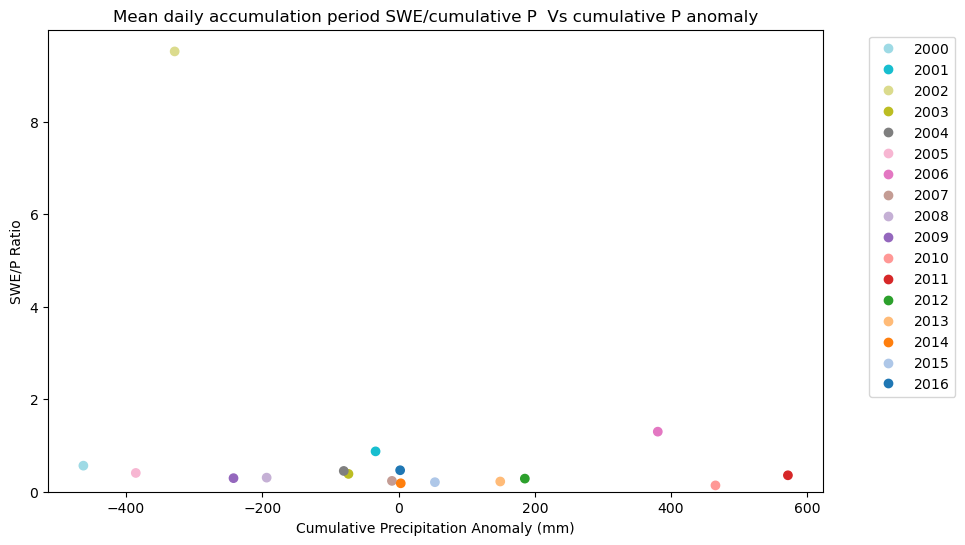

In [18]:
plt.figure(figsize=(10, 6))
ax=plt.scatter(mean_accumulation['cum_P_anom'],mean_accumulation['SWE_P_ratio'],c=mean_accumulation['season_year'],cmap='tab20_r')
plt.xlabel('Cumulative Precipitation Anomaly (mm)')
plt.ylabel('SWE/P Ratio')
plt.ylim(0)
plt.title('Mean daily accumulation period SWE/cumulative P  Vs cumulative P anomaly')
plt.legend(*ax.legend_elements(num=16),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show

In [19]:
mean_accumulation_filtere = mean_accumulation[mean_accumulation['SWE_P_ratio']<=1]

print(mean_accumulation_filtere)

    season_year      SWEmax  SWE_P_ratio  cumulative_P  cum_P_anom
0          2000  476.440000     0.563904    640.997317 -462.686079
1          2001  582.830300     0.873072   1069.900919  -33.782477
3          2003  431.103530     0.385410   1030.139653  -73.543744
4          2004  462.569895     0.449493   1023.224873  -80.458524
5          2005  438.064467     0.406075    717.952734 -385.730663
7          2007  449.917136     0.234431   1093.927389   -9.756007
8          2008  415.709654     0.304760    910.019642 -193.663754
9          2009  403.711491     0.293552    861.388864 -242.294532
10         2010  548.493599     0.137081   1568.846902  465.163506
11         2011  638.450749     0.355690   1675.213448  571.530052
12         2012  519.643683     0.283662   1289.013187  185.329790
13         2013  554.352497     0.221334   1252.932818  149.249421
14         2014  414.551555     0.182497   1106.881127    3.197731
15         2015  418.178699     0.206295   1157.024391   53.34

In [24]:
#standardize the data
mean_accumulation_filtere['cum_P_anom_z'] = (mean_accumulation_filtere['cum_P_anom'] - mean_accumulation_filtere['cum_P_anom'].mean())/mean_accumulation_filtere['cum_P_anom'].std()
mean_accumulation_filtere['SWE_P_ratio_z'] = (mean_accumulation_filtere['SWE_P_ratio'] - mean_accumulation_filtere['SWE_P_ratio'].mean())/mean_accumulation_filtere['SWE_P_ratio'].std()

print(mean_accumulation_filtere)


    season_year      SWEmax  SWE_P_ratio  cumulative_P  cum_P_anom  cluster  \
0          2000  476.440000     0.563904    640.997317 -462.686079        1   
1          2001  582.830300     0.873072   1069.900919  -33.782477        2   
3          2003  431.103530     0.385410   1030.139653  -73.543744        3   
4          2004  462.569895     0.449493   1023.224873  -80.458524        1   
5          2005  438.064467     0.406075    717.952734 -385.730663        3   
7          2007  449.917136     0.234431   1093.927389   -9.756007        0   
8          2008  415.709654     0.304760    910.019642 -193.663754        3   
9          2009  403.711491     0.293552    861.388864 -242.294532        3   
10         2010  548.493599     0.137081   1568.846902  465.163506        0   
11         2011  638.450749     0.355690   1675.213448  571.530052        3   
12         2012  519.643683     0.283662   1289.013187  185.329790        3   
13         2013  554.352497     0.221334   1252.9328

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1396610025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['cum_P_anom_z'] = (mean_accumulation_filtere['cum_P_anom'] - mean_accumulation_filtere['cum_P_anom'].mean())/mean_accumulation_filtere['cum_P_anom'].std()
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1396610025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['SWE_P_ratio_z'] = (mean_accumulation_filtere['SWE_

c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster centers:
 [[ 2.78566457 -0.10947221]
 [-0.68021251  0.74369273]
 [ 0.28226043 -0.72805384]]

Assigned clusters:
     season_year  cluster
0          2000        2
1          2001        0
3          2003        2
4          2004        2
5          2005        2
7          2007        1
8          2008        2
9          2009        2
10         2010        1
11         2011        1
12         2012        1
13         2013        1
14         2014        1
15         2015        1
16         2016        2


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\82362619.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['cluster'] = kmean.fit_predict(cluster_feature)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\82362619.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['cluster_name'] = mean_accumulation_filtere['cluster'].map(cluster_labels)


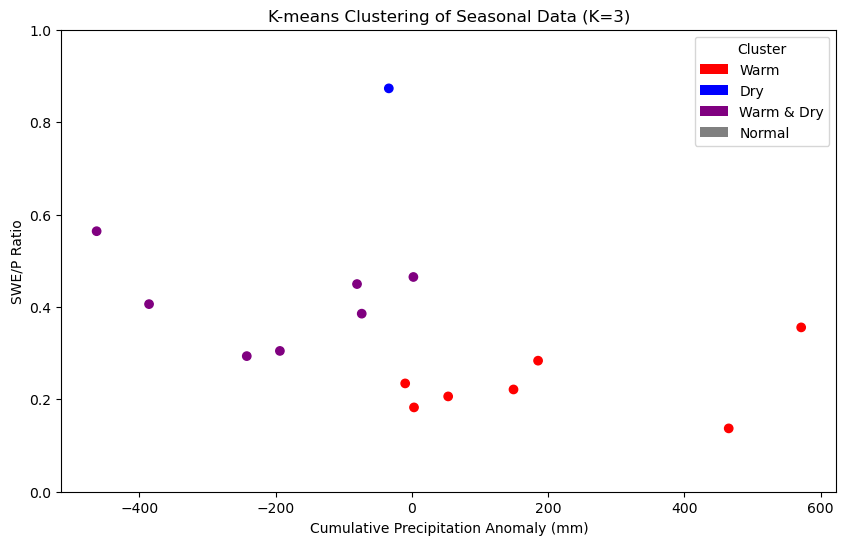

In [37]:
cluster_feature = mean_accumulation_filtere[['SWE_P_ratio_z','cum_P_anom_z']]

#K = 3
kmean = KMeans(n_clusters=3,random_state=0)

#Fit the model and predict cluster labels

mean_accumulation_filtere['cluster'] = kmean.fit_predict(cluster_feature)

# Print the cluster centers and assigned clusters
print("Cluster centers:\n", kmean.cluster_centers_)
print("\nAssigned clusters:\n", mean_accumulation_filtere[['season_year', 'cluster']])

# Assign names to clusters based on their characteristics
cluster_labels = {
    0: 'Dry',        # Replace 0, 1, 2 with the actual cluster numbers after inspection
    1: 'Warm',
    2: 'Warm & Dry'
    
}

# Map cluster numbers to names in the DataFrame
mean_accumulation_filtere['cluster_name'] = mean_accumulation_filtere['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))

# Define colors for each cluster (adjust colors as needed)
cluster_colors = {'Warm': 'red', 'Dry': 'blue', 'Warm & Dry': 'purple', 'Normal': 'grey'}

plt.scatter(mean_accumulation_filtere['cum_P_anom'],mean_accumulation_filtere['SWE_P_ratio'], c=mean_accumulation_filtere['cluster_name'].map(cluster_colors))

plt.xlabel('Cumulative Precipitation Anomaly (mm)')
plt.ylabel('SWE/P Ratio')
# Create a legend for named clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.title('K-means Clustering of Seasonal Data (K=3)')
plt.ylim(0,1)
plt.show()

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\1446498913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['season_year'] = mean_accumulation_filtere['season_year'].astype(int)


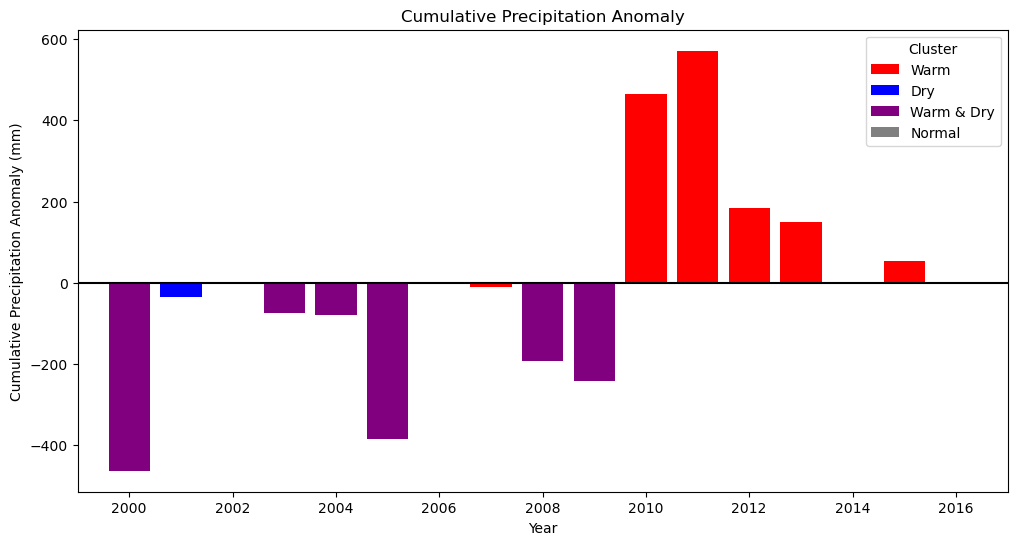

In [38]:
# Ensure 'season_year' is an integer
mean_accumulation_filtere['season_year'] = mean_accumulation_filtere['season_year'].astype(int)

plt.figure(figsize=(12, 6))

plt.bar(mean_accumulation_filtere['season_year'],mean_accumulation_filtere['cum_P_anom'],color=mean_accumulation_filtere['cluster_name'].map(cluster_colors))
plt.xlabel('Year')
plt.ylabel('Cumulative Precipitation Anomaly (mm)')
plt.title('Cumulative Precipitation Anomaly')
#Create a legend for clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.xlim(1999,2017)
plt.axhline(color='black')
plt.show()

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\3251248350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['ratio_anomaly'] = mean_accumulation_filtere['SWE_P_ratio'] - mean_accumulation_filtere['SWE_P_ratio'].mean()


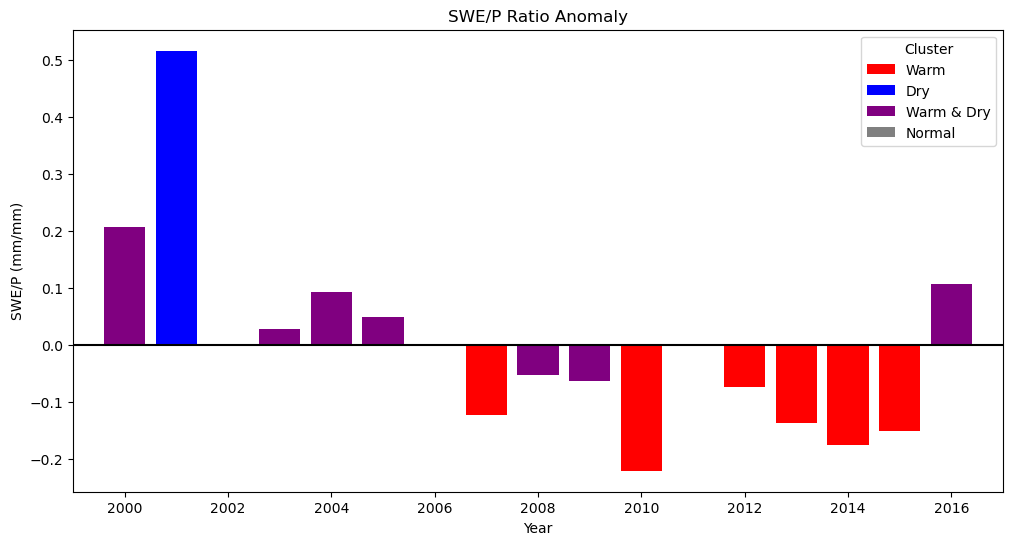

In [39]:
mean_accumulation_filtere['ratio_anomaly'] = mean_accumulation_filtere['SWE_P_ratio'] - mean_accumulation_filtere['SWE_P_ratio'].mean()

plt.figure(figsize=(12, 6))

plt.bar(mean_accumulation_filtere['season_year'],mean_accumulation_filtere['ratio_anomaly'],color=mean_accumulation_filtere['cluster_name'].map(cluster_colors))
plt.xlabel('Year')
plt.ylabel('SWE/P (mm/mm)')
plt.title('SWE/P Ratio Anomaly')
#Create a legend for clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.xlim(1999,2017)
plt.axhline(color='black')
plt.show()

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_7668\4257386128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_accumulation_filtere['peak_SWE_anomaly'] = mean_accumulation_filtere['SWEmax'] - mean_accumulation_filtere['SWEmax'].mean()


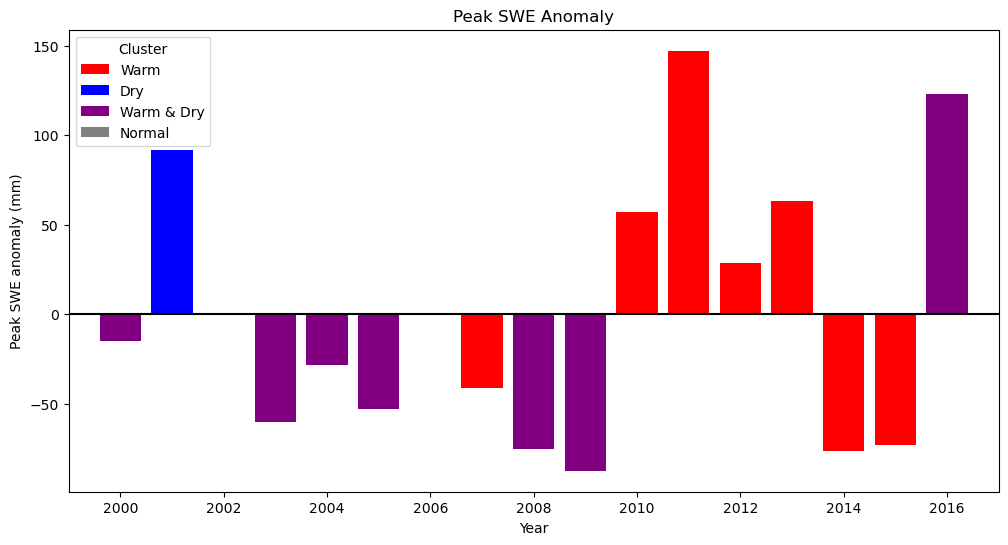

In [40]:
mean_accumulation_filtere['peak_SWE_anomaly'] = mean_accumulation_filtere['SWEmax'] - mean_accumulation_filtere['SWEmax'].mean()

plt.figure(figsize=(12, 6))

plt.bar(mean_accumulation_filtere['season_year'],mean_accumulation_filtere['peak_SWE_anomaly'],color=mean_accumulation_filtere['cluster_name'].map(cluster_colors))
plt.xlabel('Year')
plt.ylabel('Peak SWE anomaly (mm)')
plt.title('Peak SWE Anomaly')
#Create a legend for clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.xlim(1999,2017)
plt.axhline(color='black')
plt.show()

In [ ]:
SWE = xr.open_dataset(gap_filled_SWE)

SWE_testbasin = SWE.to_dataframe()

display(SWE_testbasin)

SWE  flag donor_stations        lat         lon  \
time       station_id                                                           
1979-01-01 ALE-05BA811        NaN   NaN                 51.700001 -116.466667   
           SCD-AL003          NaN   NaN                 51.183334 -115.566666   
           ALE-05BA801        NaN   NaN                 51.416668 -116.183334   
           ALE-05BA802        NaN   NaN                 51.433334 -116.166664   
           ALE-05BA806        NaN   NaN                 51.416668 -116.233330   
...                           ...   ...            ...        ...         ...   
2022-07-31 ALE-05BA814        NaN   0.0                 51.683334 -116.383331   
           ALE-05BB803        NaN   0.0                 51.083332 -115.783333   
           ALE-05CA805        NaN   0.0                 51.533333 -116.050003   
           ALE-05BB803P  40.11483   0.0                 51.083332 -115.783333   
           ALE-05CA805P   3.89600   0.0                 51.540554 -116.056389   

                                    station_name  
time       station_id                             
1979-01-01 ALE-05BA811          BOW SUMMIT (OLD)  
           SCD-AL003                       BANFF  
           ALE-05BA801                 BOW RIVER  
           ALE-05BA802           PIPESTONE UPPER  
           ALE-05BA806               MIRROR LAKE  
...                                          ...  
2022-07-31 ALE-05BA814            KATHERINE LAKE  
           ALE-05BB803          SUNSHINE VILLAGE  
           ALE-05CA805            SKOKI MOUNTAIN  
           ALE-05BB803P  SUNSHINE VILLAGE PILLOW  
           ALE-05CA805P       SKOKI LODGE PILLOW  

[222852 rows x 6 columns]